The purpose of this notebook is to test the compute_Q function in the quotient_graph.py file. We aim to replicate Figure 3 in  "*Spectral characteristic of network redundancy* " by Ben MacArthur and Ruben Sanchez-Garcia 

In [1]:
import sys
from pathlib import Path

project_root_dir = Path.cwd()
while not (project_root_dir / "tools").exists():
    project_root_dir = project_root_dir.parent
if str(project_root_dir) not in sys.path:
    sys.path.insert(0, str(project_root_dir))

from sage.all import Graph as sg
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import tools 
from tools.quotient_graph import compute_Q


In [2]:

# -- Draw networkx graph and color nodes by their orbit sets
def draw_orbit_coloring_nx(
    G: nx.Graph,
    orbits,
    pos=None,
    with_labels=True,
    node_size=50,
    font_size=10,
    edge_alpha=0.6,
    seed=1,
    cmap_name="tab20",
):
    """
    Networkx graph is drawn with nodes colored by their automorphism orbits.

    Main Parameters
    ----------
    G : networkx.Graph
        Input graph.

    orbits : list of iterable
        Automorphism orbit partition of the vertex set.

    pos : dict, optional
        Node positions for drawing. If None, positions are computed using
        a force-directed (spring) layout.

    Returns
    -------
    node_to_orbit : dict
        Mapping from nodes to orbit indices.

    pos : dict
        Layout positions used in the visualization.
    """


    # Make sure each orbit is a set
    orbits = [set(orb) for orb in orbits]

    # Build node -> orbit index mapping
    node_to_orbit = {}
    for k, orb in enumerate(orbits):
        for v in orb:
            node_to_orbit[v] = k

    # Sanity: ensure every node is assigned (if not, put in its own orbit)
    missing = [v for v in G.nodes() if v not in node_to_orbit]
    if missing:
        start = len(orbits)
        for i, v in enumerate(missing):
            node_to_orbit[v] = start + i
        orbits = orbits + [{v} for v in missing]

    # Layout
    if pos is None:
        pos = nx.spring_layout(G, seed=seed)

    # Convert orbit indices -> colors via a colormap
    orbit_ids = [node_to_orbit[v] for v in G.nodes()]
    cmap = mpl.colormaps.get_cmap(cmap_name)
    norm = mpl.colors.Normalize(vmin=min(orbit_ids), vmax=max(orbit_ids))

    node_colors = [cmap(norm(node_to_orbit[v])) for v in G.nodes()]

    plt.figure(figsize=(6, 5))
    nx.draw_networkx_edges(G, pos, alpha=edge_alpha)
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=node_size)
    if with_labels:
        nx.draw_networkx_labels(G, pos, font_size=font_size)
    plt.axis("off")
    plt.show()

    return node_to_orbit, pos


In [3]:
### For visual reasons: let's create a position coordinate for each node to look like Figure 3a 

# -- Helper function:  place nodes evenly around a circle
def radial_positions(center, nodes, radius=1.0, angle_offset=0.0):
    cx, cy = center
    n = len(nodes)
    angles = np.linspace(0, 2*np.pi, n, endpoint=False) + angle_offset
    return {v: (cx + radius*np.cos(a), cy + radius*np.sin(a)) for v, a in zip(nodes, angles)}

def create_node_pos(G=None, x_spacing=2.0):
    """
     Create positions for nodes to look like the Fig-3a graph.

    Parameters
    ----------
    G : networkx.Graph, optional
        If provided, any nodes missing from the handcrafted layout will be
        assigned positions from a spring-layout fallback (prevents KeyError).
    x_spacing : float
        Horizontal spacing between backbone nodes.

    Returns
    -------
    pos : dict
        Node -> (x, y) positions usable as the `pos` argument in NetworkX drawing.
    """
    pos = {}

    # -------------------------
    # Backbone
    # -------------------------
    backbone = ["w0", "w1", "w2", "w3", "w4", "w5"]
    for i, v in enumerate(backbone):
        pos[v] = (i * x_spacing, 0.0)

    w0x, w0y = pos["w0"]
    w1x, w1y = pos["w1"]
    w2x, w2y = pos["w2"]
    w3x, w3y = pos["w3"]
    w4x, w4y = pos["w4"]
    w5x, w5y = pos["w5"]

    # -------------------------
    # Left S2 motifs off w0
    # -------------------------
    pos["l1_g"] = (w0x - 1.0,  0.9)
    pos["l1_b"] = (w0x - 2.0,  1.3)

    pos["l2_g"] = (w0x - 1.0, -0.9)
    pos["l2_b"] = (w0x - 2.0, -1.3)

    # -------------------------
    # Top-left motif off w1
    # -------------------------
    pos["tl_w"]  = (w1x,  1.3)
    pos["tl1_g"] = (w1x - 0.9,  2.1)
    pos["tl2_g"] = (w1x + 0.9,  2.1)

    pos["tl1_b"] = (w1x - 0.9,  3.0)
    pos["tl2_b"] = (w1x + 0.9,  3.0)

    # -------------------------
    # Triangle motif off w1 (below)
    # -------------------------
    tri = ["t1", "t2", "t3"]
    pos.update(radial_positions(center=(w1x, -1.4), nodes=tri, radius=0.65, angle_offset=np.pi/6))

    # -------------------------
    # S4 star off w2 via intermediate hub "sw"
    # -------------------------
    pos["sw"] = (w2x, 1.0)
    s4_leaves = ["s4_b1", "s4_b2", "s4_b3", "s4_b4"]
    pos.update(radial_positions(center=(w2x, 2.1), nodes=s4_leaves, radius=0.75, angle_offset=np.pi/4))

    # -------------------------
    # Diamond-like crossed gadget between w3 and w4
    # -------------------------
    midx = 0.5*(w3x + w4x)
    pos["d1_g"] = (midx,  0.9)
    pos["d1_b"] = (midx,  1.7)

    pos["d2_g"] = (midx, -0.9)
    pos["d2_b"] = (midx, -1.7)

    # -------------------------
    # Right motif: two arms off w5, each arm has two leaves
    # -------------------------

    pos["r1_g"] = (w5x + 1.0,  0.8)
    pos["r2_g"] = (w5x + 1.0, -0.8)

    pos["r1_b1"] = (w5x + 2.0,  1.2)
    pos["r1_b2"] = (w5x + 2.0,  0.4)

    pos["r2_b1"] = (w5x + 2.0, -0.4)
    pos["r2_b2"] = (w5x + 2.0, -1.2)

    # -------------------------
    # Ensure every node has a position
    # -------------------------
    if G is not None:
        missing = [v for v in G.nodes() if v not in pos]
        if missing:
            pos_fallback = nx.spring_layout(G, seed=1)
            for v in missing:
                pos[v] = pos_fallback[v]

    return pos


In [4]:


def quotient_positions_representative(partition, pos, strategy="max_abs_y"):
    """
    Place each quotient node using a representative member of the block/orbit.
    """
    pos_Q = {}

    for block in partition:
        block = list(block)

        if strategy == "first":
            rep = block[0]

        elif strategy == "max_abs_y":
            rep = max(block, key=lambda v: abs(pos[v][1]))

        elif strategy == "max_abs_y_above":
            # prefer a rep above the axis if possible
            above = [v for v in block if pos[v][1] > 0]
            rep = max(above, key=lambda v: pos[v][1]) if above else max(block, key=lambda v: abs(pos[v][1]))

        else:
            raise ValueError("Unknown strategy")

        pos_Q[frozenset(block)] = pos[rep]

    return pos_Q


In [5]:
# Create networks in Figure 3

# For node label readability: w= white node, b = black node, g= grey node, l= left, r= right,  tl= top left,  d= diamond, s = star
#These are based on Figure 3a in the paper 
edge_list = [

    # Backbone
    ("w0", "w1"),
    ("w1", "w2"),
    ("w2", "w3"),
    ("w3", "w4"),
    ("w4", "w5"),

    # Left S2 motifs
    ("w0", "l1_g"), ("l1_g", "l1_b"),
    ("w0", "l2_g"), ("l2_g", "l2_b"),

    # Top left  S2 motifs 
    ("w1", "tl_w"), 
    ("tl_w", "tl1_g"), 
    ("tl_w", "tl2_g"), 
    ("tl1_g", "tl1_b"),
    ("tl1_g","tl2_b" ), 
    ("tl2_g","tl1_b"),
    ("tl2_g","tl2_b"),




    # S4 star
    ("w2", "sw"),
    ("sw", "s4_b1"),
    ("sw", "s4_b2"),
    ("sw", "s4_b3"),
    ("sw", "s4_b4"),

    # Triangle motif
    ("w1", "t1"),
    ("w1", "t2"),
    ("w1", "t3"),
    ("t1", "t2"),
    ("t2", "t3"),
    ("t3", "t1"),

    # Diamond motif
    ("w3", "d1_g"), 
    ("d1_g", "d1_b"), 
    ("d1_g", "w4"), 
    ("w4", "d2_g"), 
    ("d2_g", "d2_b"), 
    ("d2_g", "w3"), 


    # Right S3 motif
    ("w5", "r1_g"), ("r1_g", "r1_b1"), ("r1_g", "r1_b2"),
    ("w5", "r2_g"), ("r2_g", "r2_b1"), ("r2_g", "r2_b2")

]

G = nx.Graph()
G.add_edges_from(edge_list)

#Compute orbits of this network
orbits, Q = compute_Q(G)


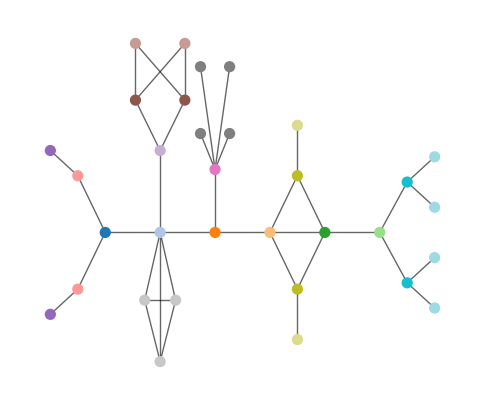

In [6]:
#Figure 3a - draw original network and color but orbit set
pos = create_node_pos(G)  # get node positions for fig 3a
node_to_orbit, pos_G = draw_orbit_coloring_nx(G, orbits, pos=pos, with_labels = False)

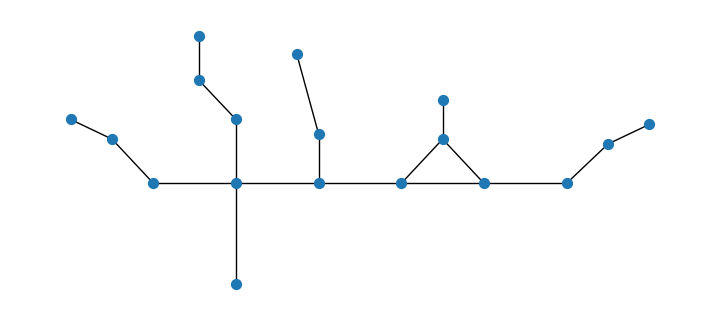

In [7]:
#Figure 3b

pos_Q = quotient_positions_representative(orbits, pos_G, strategy="max_abs_y_above")  # get node positions for fig 3b
plt.figure(figsize=(7,3))
nx.draw(Q, pos_Q, with_labels=False, node_size=50)
plt.axis("off")
plt.show()